# **<span style="color:#F7B2B0;">Goal / Problem Statement</span>**

**Target**: DiagPeriodL90D: Diagnosis Period Less Than 90 Days. This is an indication of whether the cancer was diagnosed within 90 Days.

# **<span style="color:#F7B2B0;">Data Description</span>**
The WiDS Datathon 2024 focuses on a prediction task using a roughly 39k record dataset (split into training and test sets) representing patients and their characteristics (age, race, BMI, zip code), their diagnosis and treatment information (breast cancer diagnosis code, metastatic cancer diagnosis code, metastatic cancer treatments, … etc.), their geo (zip-code level) demographic data (income, education, rent, race, poverty, …etc), as well as toxic air quality data (Ozone, PM25 and NO2) that tie health outcomes to environmental conditions. Each row in the data corresponds a single patient and her Diagnosis Period. Your task is to assess whether the likelihood of the patient’s Diagnosis Period being less than 90 days is predictable using these characteristics and information about the patient.

# **<span style="color:#F7B2B0;">Model Evaluation Metric</span>**

Submissions for the leaderboard will be evaluated on the Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target DiagPeriodL90D. Learn more about AUC in this developer crash course, this video, or this Kaggle Learn Forum post.

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
# pip install tpot

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Data Processing
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import regex

### Data Stats
from scipy import stats
# import statsmodels.formula.api as sm
import statsmodels.api as sm
# from backwardElimination import backwardElimination

### Handling Missing Values
from sklearn.impute import SimpleImputer

### Data Transformation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder

# from tpot import TPOTClassifier
from catboost import Pool, CatBoostClassifier

### Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')
import seaborn as sns

### ML Model Building
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### ML Models/Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC #LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### ML Model Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import GridSearchCV

print('Libraries Imported!')

Libraries Imported!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df_train = pd.read_csv(r'C:/Users/Aditya Mangla/Desktop/Wells Fargo/Hackathon/WiDS_2024/widsdatathon2024-challenge1/training.csv')
df_train = pd.read_csv(r'/content/drive/MyDrive/2_WiDS-Datathon-Kaggle_Jan24_healthCare/dataset/training.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/2_WiDS-Datathon-Kaggle_Jan24_healthCare/dataset/test.csv')
sample_submission = pd.read_csv(r'/content/drive/MyDrive/2_WiDS-Datathon-Kaggle_Jan24_healthCare/dataset/test.csv')

# print("Train No of Rows \t === ", df_train.shape[0])
# print("Train No of Columns \t === ", df_train.shape[1])

print('Train Dimension === ', df_train.shape)
# print('Train Columns === ', df_train.columns) #.to_list())

print('Test Dimension === ', df_test.shape)

Train Dimension ===  (12906, 83)
Test Dimension ===  (5792, 82)


In [ ]:
df_train.head(3)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1


In [ ]:
# df_train.describe().style.background_gradient(cmap="Pastel1")

# Data Overview

In [ ]:
df_train.info()
# df_train.select_dtypes(include=['object']).columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [ ]:
# print('NANs === ', df_train.isna().sum().sum()) # 101772

# missingValCnt = df_train.isna().sum()
# # missingValCnt.ne(0)

# df_missing = pd.DataFrame(missingValCnt.rename('NANs')).loc[missingValCnt.ne(0)]

# df_missing

In [ ]:
print(df_train['DiagPeriodL90D'].isna().sum())
print(df_train['DiagPeriodL90D'].shape)
print(df_train['DiagPeriodL90D'].value_counts())

# print(df_train['DiagPeriodL90D'].value_counts(normalize='bins'))
df_train['DiagPeriodL90D'].value_counts(normalize=True)*100

0
(12906,)
1    8060
0    4846
Name: DiagPeriodL90D, dtype: int64


1    62.451573
0    37.548427
Name: DiagPeriodL90D, dtype: float64

In [ ]:
df_train['patient_gender'].value_counts()

F    12906
Name: patient_gender, dtype: int64

In [ ]:
# df_train['female'].head(6)

In [ ]:
df_train['patient_age'].describe()

count    12906.000000
mean        59.183326
std         13.335216
min         18.000000
25%         50.000000
50%         59.000000
75%         67.000000
max         91.000000
Name: patient_age, dtype: float64

In [ ]:
### Age Groups
# df_train['patient_age'].value_counts(bins=10)
df_train['patient_age'].value_counts(bins=8)
# df_train['patient_age'].value_counts(bins=6)

(54.5, 63.625]      3877
(45.375, 54.5]      2763
(63.625, 72.75]     2329
(36.25, 45.375]     1354
(81.875, 91.0]      1235
(72.75, 81.875]      807
(27.125, 36.25]      455
(17.926, 27.125]      86
Name: patient_age, dtype: int64

# Handling Highly missing values and categorical data


In [ ]:
df_NotNAN = df_train.loc[:, ~df_train.isna().any()]
print(df_NotNAN.shape, df_NotNAN.columns)

# calculate percentage of missing data in each column and print it
# create new df with columns with missing values
df_missing_cols_1 = df_train.loc[:, df_train.isna().any()]
print()
print(df_train.shape, df_missing_cols_1.shape)
# print(df_missing_cols_1.columns)
print()

df_missing_cols_1_per = (df_missing_cols_1.isna().sum() / len(df_missing_cols_1)) * 100

for column, percent in zip(df_missing_cols_1.columns, df_missing_cols_1_per):
  if percent>=40:
    print(f"Column: {column}, Missing Data Percentage: {percent:.2f}%")

(12906, 8) Index(['patient_id', 'patient_zip3', 'patient_age', 'patient_gender',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'DiagPeriodL90D'],
      dtype='object')

(12906, 83) (12906, 75)

Column: patient_race, Missing Data Percentage: 49.47%
Column: bmi, Missing Data Percentage: 69.46%
Column: metastatic_first_novel_treatment, Missing Data Percentage: 99.81%
Column: metastatic_first_novel_treatment_type, Missing Data Percentage: 99.81%


## prompt: list the  columns with missing data more than 40 percent

In [ ]:
# df_missing_cols_per = round((df_missing_cols.isna().sum() / len(df_missing_cols)) * 100, 2)
# print(df_missing_cols_per.sample(6))

lst_missing_cols_high = df_missing_cols_1_per[df_missing_cols_1_per > 40].index.tolist()
print(lst_missing_cols_high)

['patient_race', 'bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']


## prompt: drop columns in df_missing_cols_more_than_40 from df_train

In [ ]:
df_train_proc_1 = df_train.drop(columns=lst_missing_cols_high)
print(df_train.shape, df_train_proc_1.shape)
# df_train_proc_1.columns

(12906, 83) (12906, 79)


In [ ]:
print('NANs in Raw-Data: ', df_train.isna().sum().sum())
print('NANs in Preproc-Data: ', df_train_proc_1.isna().sum().sum())
print()
df_train_proc_1.isna().sum()
# Column: payer_type, Missing Data Percentage: 13.97%

NANs in Raw-Data:  43292
NANs in Preproc-Data:  2178



patient_id           0
payer_type        1803
patient_state       51
patient_zip3         0
patient_age          0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 79, dtype: int64

In [ ]:
print(df_train_proc_1['payer_type'].shape)
print(df_train_proc_1['payer_type'].isna().sum())
df_train_proc_1['payer_type'].value_counts()

(12906,)
1803


COMMERCIAL            6032
MEDICAID              2569
MEDICARE ADVANTAGE    2502
Name: payer_type, dtype: int64

In [ ]:
# # 1. Count plot
# # _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# # sns.countplot(x='payer_type', data=df_train_proc_1, ax=axes[0])
# # sns.countplot(x='patient_state', data=df_train_proc_1, ax=axes[1])

# # 2. Count plot
# plt.figure(figsize=(5, 3))
# sns.countplot(x='payer_type', data=df_train_proc_1, hue='DiagPeriodL90D')

In [ ]:
# plt.figure(figsize=(5, 3))
# sns.countplot(x='payer_type', data=df_train_proc_1)

In [ ]:
print(df_train_proc_1['patient_state'].isna().sum())
print(df_train_proc_1['patient_state'].value_counts()[:5])

51
CA    2438
TX    1155
NY    1041
MI     858
IL     782
Name: patient_state, dtype: int64


In [ ]:
# # 3. Count Plot
# plt.figure(figsize=(14,6))
# ax = sns.countplot(x="patient_state", data=df_train_proc_1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40)  #, ha="right") # , fontsize=8)
# # plt.tight_layout()
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 6))
# sns.countplot(x='patient_state', data=df_train_proc_1, hue='DiagPeriodL90D')

In [ ]:
df_train_proc_1['Region'].value_counts()

South        3919
West         3735
Midwest      3650
Northeast    1550
Name: Region, dtype: int64

In [ ]:
# # plt.figure(figsize=(5,5))
# sns.countplot(x='Region', data=df_train_proc_1, hue='DiagPeriodL90D')

In [ ]:
df_train_proc_1['Division'].value_counts()

East North Central    2923
Pacific               2754
South Atlantic        1972
Middle Atlantic       1545
West South Central    1450
Mountain               981
West North Central     727
East South Central     497
New England              5
Name: Division, dtype: int64

In [ ]:
# plt.figure(figsize=(10,4))
# sns.countplot(x='Division', data=df_train_proc_1, hue='DiagPeriodL90D')

In [ ]:
# # 3. Count Plot
# plt.figure(figsize=(14,6))
# ax = sns.countplot(x="breast_cancer_diagnosis_code", data=df_train_proc_1)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)  #, ha="right") # , fontsize=8)
# # plt.tight_layout()
# plt.show()

In [ ]:
df_train_proc_1[['population', 'density']].head(3)

,population,density
0,31437.75000,1189.562500
1,39121.87879,2295.939394
2,21996.68333,626.236667


## Drop NANs - Better Impute Missing Values

In [ ]:
print('NANs Before Impute: ', df_train_proc_1['payer_type'].isna().sum())

df_train_proc = df_train_proc_1.copy(deep=True)

# print('*' * 80)
print()
df_train_proc['payer_type'] = df_train_proc_1['payer_type'].fillna(df_train_proc_1['payer_type'].mode()[0])
print('NANs After Impute: ', df_train_proc['payer_type'].isna().sum())
df_train_proc['payer_type'].value_counts() ### NANs replaced by Commercial this being the Mode of the 3 Values

NANs Before Impute:  1803

NANs After Impute:  0


COMMERCIAL            7835
MEDICAID              2569
MEDICARE ADVANTAGE    2502
Name: payer_type, dtype: int64

In [ ]:
# calculate percentage of missing data in each column and print it
# create new df with columns with missing values
df_missing_cols_2 = df_train_proc.loc[:, df_train_proc.isnull().any()]
print('df_train_proc vs df_missing_cols_2: ', df_train_proc.shape, df_missing_cols_2.shape)

print('NANs Raw Vs PreProc-1 Vs PreProc-2 (Dataset after imputing Payer_Type has still 70 Cols with NANs) === ')
print(df_train.shape, df_train_proc.shape, len(df_missing_cols_2.columns))
### 8 of the Original columns do not have any NANs, so 71 NAN Cols, after removing 4 NAN cols having >=40% Missing Values
### 7 of this Preprocessed Columns have >=0.20%; payer_type being the highest - 13.97%

print()
df_missing_cols_per_2 = (df_missing_cols_2.isna().sum() / len(df_missing_cols_2)) * 100

for column, percent in zip(df_missing_cols_2.columns, df_missing_cols_per_2):
  if (percent >= 0.2): # 0.20%, 0.40%, 13.97%
    print(f"Column: {column}, Missing Data Percentage: {percent:.2f}%")

### ****************** Column: DiagPeriodL90D, Missing Data Percentage: 0.40%
# Column: payer_type, Missing Data Percentage: 13.97%

df_train_proc vs df_missing_cols_2:  (12906, 79) (12906, 70)
NANs Raw Vs PreProc-1 Vs PreProc-2 (Dataset after imputing Payer_Type has still 70 Cols with NANs) === 
(12906, 83) (12906, 79) 70

Column: patient_state, Missing Data Percentage: 0.40%
Column: Region, Missing Data Percentage: 0.40%
Column: Division, Missing Data Percentage: 0.40%
Column: Ozone, Missing Data Percentage: 0.22%
Column: PM25, Missing Data Percentage: 0.22%
Column: N02, Missing Data Percentage: 0.22%


In [ ]:
print(df_train_proc.shape, df_train_proc.isna().sum().sum())

df_train_clean_1 = df_train_proc.copy(deep=True)

imputer_Numeric_Mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_String_Mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

lst_missing_cols_train = df_train_clean_1.columns[df_train_clean_1.isna().any()]
print('NAN Columns to handle in Train: ', len(lst_missing_cols_train)) ### 4 Dropped for >40% Missing => 83-4=79; 8 for no NANs => 79-8=71

for col in lst_missing_cols_train:
  if df_train_clean_1[col].dtype == 'object':
    df_train_clean_1[col] = imputer_String_Mode.fit_transform(df_train_clean_1[[col]]).reshape(-1,1)
    # print(df_train_clean_2[col].head(2))
  else:
    df_train_clean_1[col] = imputer_Numeric_Mean.fit_transform(df_train_clean_1[[col]])

print('*'*80)
print('Any More NANs after Impute (Numeric: Mean; Categorical- Mode/Most-Frequent)?')
print(df_train_clean_1.shape, df_train_clean_1[col].isna().sum().sum())
# df_train_clean_1['payer_type'][0] ### MEDICAID

(12906, 79) 375
NAN Columns to handle in Train:  70
********************************************************************************
Any More NANs after Impute (Numeric: Mean; Categorical- Mode/Most-Frequent)?
(12906, 79) 0


## Test Dataset Pre-processing

In [ ]:
print(df_test.shape)
print(df_test.isna().sum().sum())
# patient_race        2901
# payer_type           760
# patient_state         21

df_test_proc_1 = df_test.drop(columns=lst_missing_cols_high)
print('Drop 40% missed Cols as per Train Dataset: ', df_test.shape, df_test_proc_1.shape)
### To have Train & Test of same Features
print('Before Mode Impute Test: ', df_test_proc_1['payer_type'].isna().sum())
print(df_test_proc_1['payer_type'].value_counts())
print()

df_test_proc = df_test_proc_1.copy(deep=True)
df_test_proc['payer_type'] = df_test_proc_1['payer_type'].fillna(df_test_proc_1['payer_type'].mode()[0])
print('Test Dataset Fill payer_type NANs with Mode: ', df_test_proc['payer_type'].isna().sum())
print('After Before Mode Impute Test: ', df_test_proc['payer_type'].isna().sum())
print(df_test_proc['payer_type'].value_counts()) ### NANs replaced by Commercial this being the Mode of the 3 Values

print()
df_test_clean_1 = df_test_proc.copy(deep=True)

lst_missing_cols_test = df_test_clean_1.columns[df_test_clean_1.isna().any()]
print('NAN Columns to handle in Test: ', len(lst_missing_cols_test)) ### 4 Dropped for >40% Missing => 83-4=79; 8 for no NANs => 79-8=71

for col in lst_missing_cols_test:
  if df_test_clean_1[col].dtype == 'object':
    df_test_clean_1[col] = imputer_String_Mode.fit_transform(df_test_clean_1[[col]]).reshape(-1,1)
    # print(df_train_clean_1[col].head(2))
  else:
    df_test_clean_1[col] = imputer_Numeric_Mean.fit_transform(df_test_clean_1[[col]])

# print('*'*80)
print()
print('Any More NANs after Impute (Numeric: Mean; Categorical- Mode/Most-Frequent)?')
print(df_test_clean_1.shape, df_test_clean_1[col].isna().sum().sum())

(5792, 82)
19366
Drop 40% missed Cols as per Train Dataset:  (5792, 82) (5792, 78)
Before Mode Impute Test:  760
COMMERCIAL            2759
MEDICARE ADVANTAGE    1151
MEDICAID              1122
Name: payer_type, dtype: int64

Test Dataset Fill payer_type NANs with Mode:  0
After Before Mode Impute Test:  0
COMMERCIAL            3519
MEDICARE ADVANTAGE    1151
MEDICAID              1122
Name: payer_type, dtype: int64

NAN Columns to handle in Test:  29

Any More NANs after Impute (Numeric: Mean; Categorical- Mode/Most-Frequent)?
(5792, 78) 0


## Categorical Columns - Label/Target Encoding

In [ ]:
# # prompt: from df_train get all categorical data columns
cat_cols_1 = df_train_clean_1.select_dtypes(include=['object']).columns.tolist()
print('All Cat Cols: ', len(cat_cols_1)) #, '-', cat_cols_1)
print('cat_cols_1: ', cat_cols_1)

df_train_clean = df_train_clean_1.drop(columns = cat_cols_1 + ['patient_id'])
### Drop Categorical Columns that are not needed so Patient_ID column as well
print('Train: ', df_train_clean_1.shape, df_train_clean.shape)
# df_train_trans.select_dtypes(include=['object']).columns

print('+'*80)
df_test_clean = df_test_clean_1.drop(columns = cat_cols_1 + ['patient_id'])
print('Test: ', df_test_clean_1.shape, df_test_clean.shape)

All Cat Cols:  8
cat_cols_1:  ['payer_type', 'patient_state', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']
Train:  (12906, 79) (12906, 70)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Test:  (5792, 78) (5792, 69)


In [ ]:
cat_Enc_cols = ['payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']

for col in cat_Enc_cols:
  # print('+'*80)
  print(col, ':: ', len(df_train_clean_1[col].value_counts()))
  # print(df_train_clean_1[col].value_counts())

  ### All Catyegorical Columns look Ordinal data so Try 1-Hot Encoding

payer_type ::  3
patient_state ::  50
breast_cancer_diagnosis_code ::  50
metastatic_cancer_diagnosis_code ::  43
Region ::  4
Division ::  9


In [ ]:
### Identify any Unseen Labels/Categories
for col in cat_Enc_cols:
  unknown_cat = set(df_test_clean_1[col]) - set(df_train_clean_1[col])
  print('unknown_cat: for ', col, ' is: ', list(unknown_cat))

# print(df_test_clean_1[df_test_clean_1['breast_cancer_diagnosis_code'] == 'C50922']['breast_cancer_diagnosis_code'])
# print(df_train_clean_1[df_train_clean_1['breast_cancer_diagnosis_code'] == 'C50922']['breast_cancer_diagnosis_code'])

# ### this value of Code is available in Test dataset and not in Train, so we cant perform label encoding on this new value which is not fit
# ### so drop such records in all Categorical Columns on which we perform Encoding

unknown_cat: for  payer_type  is:  []
unknown_cat: for  patient_state  is:  []
unknown_cat: for  breast_cancer_diagnosis_code  is:  ['C50922', 'C50921']
unknown_cat: for  metastatic_cancer_diagnosis_code  is:  []
unknown_cat: for  Region  is:  []
unknown_cat: for  Division  is:  []


In [ ]:
# Ordinal Data - Use Label Encoding - This type brings Ordering
# Nominal Data - Use One-Hot Encoding - no Ingerant Order

# labelEnc_Ordinal_cols = ['patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']
# onehot_Nominal_cols = ['payer_type']

print('cat_Enc_cols: ', len(cat_Enc_cols), cat_Enc_cols)
print()

cat_tarEnc = TargetEncoder()
cat_tarEnc.fit(X=df_train_clean_1[cat_Enc_cols], y=df_train_clean_1['DiagPeriodL90D'])

### **********************************************************************************************************************

train_cat_tarEnc = cat_tarEnc.transform(X=df_train_clean_1[cat_Enc_cols]) #, y=df_train_clean_1['DiagPeriodL90D'])
# print('Train: ', train_cat_tarEnc.head(2))
print()

df_train_trans = pd.concat([df_train_clean, train_cat_tarEnc], axis=1)
print('Train: ', df_train_trans.shape) #, df_train_trans.columns) ### 71 from above + 6 Encoded Features = 77
# df_train_trans.head(6)

### **********************************************************************************************************************

test_cat_tarEnc = cat_tarEnc.transform(X=df_test_clean_1[cat_Enc_cols]) #, y=df_train_clean_1['DiagPeriodL90D'])
# print('Test: ', test_cat_tarEnc.head(2))

df_test_trans = pd.concat([df_test_clean, test_cat_tarEnc], axis=1)
print('Test: ',df_test_trans.shape) #, df_test_trans.columns) ### 71 from above + 6 Encoded Features = 77
df_test_trans.head(3)


cat_Enc_cols:  6 ['payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']


Train:  (12906, 76)
Test:  (5792, 75)


,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,veteran,Ozone,PM25,N02,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division
0,467,54,5441.435484,85.620968,40.880328,12.732258,14.088710,10.659677,11.625806,11.208065,...,8.080645,38.724876,7.947165,11.157161,0.610354,0.611987,0.797035,0.668888,0.632055,0.624538
1,337,52,19613.820510,1555.107692,49.107692,8.069231,8.587179,10.684615,11.302564,10.971795,...,9.302564,36.918257,7.838973,13.599985,0.623484,0.633826,0.776869,0.643646,0.604130,0.605477
2,917,61,43030.500000,2048.578261,38.852174,11.306522,12.897826,14.121739,13.532609,13.160870,...,3.810870,47.310325,9.595719,20.084231,0.610354,0.646846,0.788536,0.668888,0.653280,0.644154


In [ ]:
df_train_trans[['payer_type',	'patient_state',	'breast_cancer_diagnosis_code',	'metastatic_cancer_diagnosis_code',	'Region',	'Division', 'DiagPeriodL90D']].sample(3)


,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division,DiagPeriodL90D
8254,0.623484,0.633826,0.776869,0.668888,0.60413,0.605477,0
6688,0.610354,0.564384,0.776869,0.565689,0.60413,0.605477,0
8523,0.623484,0.598268,0.788536,0.643646,0.60413,0.610345,1


In [ ]:
df_test_trans[['payer_type',	'patient_state',	'breast_cancer_diagnosis_code',	'metastatic_cancer_diagnosis_code',	'Region',	'Division']].sample(3)

,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division
2920,0.623484,0.679245,0.783231,0.668888,0.632055,0.624538
5158,0.623484,0.598268,0.780504,0.648936,0.604130,0.610345
3333,0.623484,0.658508,0.828921,0.415418,0.632055,0.624538


## Correlation of Features

In [ ]:
feature_corr_ = df_train_trans.select_dtypes(include='number').corr(method='pearson')
feature_corr = abs(feature_corr_)
feature_corr.head()

,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,Ozone,PM25,N02,DiagPeriodL90D,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division
patient_zip3,1.000000,0.062820,0.098966,0.196666,0.148135,0.057005,0.032372,0.095137,0.166870,0.077963,...,0.390313,0.066877,0.073533,0.036372,0.055844,0.364274,0.029574,0.011102,0.793175,0.709629
patient_age,0.062820,1.000000,0.018046,0.002532,0.040118,0.026530,0.029745,0.020618,0.023542,0.025754,...,0.025887,0.022992,0.014835,0.055634,0.459250,0.042193,0.012285,0.087589,0.033080,0.006452
population,0.098966,0.018046,1.000000,0.730978,0.550534,0.254734,0.000769,0.437070,0.636995,0.396377,...,0.081313,0.385252,0.672193,0.006575,0.040574,0.041819,0.001476,0.054576,0.055814,0.001336
density,0.196666,0.002532,0.730978,1.000000,0.335151,0.105550,0.164597,0.299683,0.522595,0.207678,...,0.124993,0.199301,0.578565,0.017285,0.005728,0.138746,0.022229,0.049764,0.164879,0.175145
age_median,0.148135,0.040118,0.550534,0.335151,1.000000,0.530657,0.471295,0.784668,0.678690,0.173072,...,0.053401,0.462435,0.486574,0.000404,0.036691,0.039025,0.003602,0.014430,0.013773,0.004384


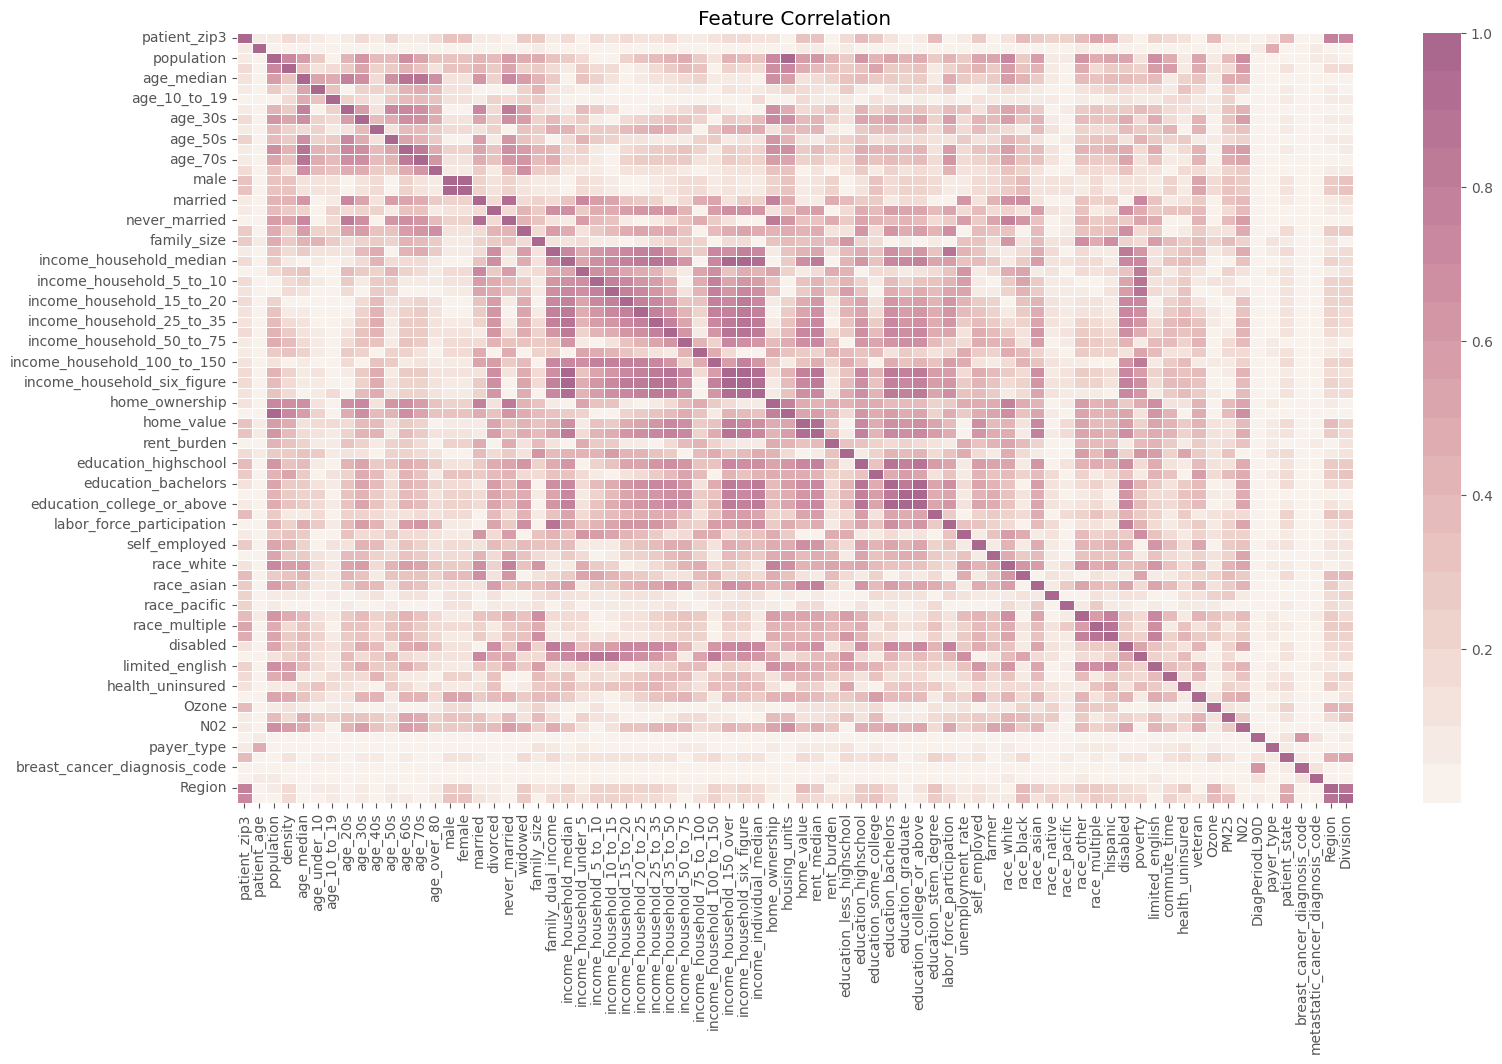

In [ ]:
plt.figure(figsize=(18,10)) #, dpi=500)
sns.heatmap(feature_corr, cmap=sns.cubehelix_palette(20, light=0.95, dark=0.5), linewidth=0.5).set_title("Feature Correlation")
plt.show()
### -0.75 to 1.0

# sns.heatmap(corr, cmap='Greens') # , annot=True)

## Selection of Features based on Correlation

In [ ]:
# Compare the Correlation between Features and remove one of two features that have a Correlation Higher than 0.9
# print(feature_corr.shape[0]) # 77

columns = np.full((feature_corr.shape[0],), True, dtype=bool)
### feature_corr - Correlation DF, so 77*77 Dim
print('Columns: ', len(columns)) ### [True....] ### 77 - Array of Same Length & Datatype is Created here
# columns

for i in range(feature_corr.shape[0]):
    for j in range(i+1, feature_corr.shape[0]):
      # print('feature_corr.iloc[i,j]: ', i, j, feature_corr.iloc[i,j])

      # if feature_corr.iloc[i,j] >= 0.9: ### 68 Features got Selected
      # if feature_corr.iloc[i,j] >= 0.5: ### 16 Features got Selected
      # if feature_corr.iloc[i,j] >= 0.75: ### 45 Features got Selected
      # if feature_corr.iloc[i,j] >= 0.80: ### 55 Features got Selected
      if feature_corr.iloc[i,j] >= 0.70: ### 40 Features got Selected
        if columns[j]:
          # print('columns[j]: ', i, j, columns[j])
          columns[j] = False

# print('selected_columns_corr: ', columns)

selected_columns_corr = feature_corr.columns[columns]
print('No of Selected Columns: ', len(selected_columns_corr)) # 180
print(selected_columns_corr)

print('Dimension Before Selecting Columns: ', df_train_trans.shape) # (352604, 235)
df_train_corr = df_train_trans[selected_columns_corr]
print('Dimension After Selecting Columns: ', df_train_corr.shape) # (352604, 175)

Columns:  76
No of Selected Columns:  40
Index(['patient_zip3', 'patient_age', 'population', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_over_80',
       'male', 'divorced', 'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_50_to_75',
       'income_household_75_to_100', 'rent_burden',
       'education_less_highschool', 'education_some_college',
       'education_stem_degree', 'unemployment_rate', 'self_employed', 'farmer',
       'race_black', 'race_native', 'race_pacific', 'race_other',
       'race_multiple', 'commute_time', 'health_uninsured', 'veteran', 'Ozone',
       'PM25', 'N02', 'DiagPeriodL90D', 'payer_type', 'patient_state',
       'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code'],
      dtype='object')
Dimension Before Selecting Columns:  (12906, 76)
Dimension After Selecting Columns:  (12906, 40)


In [ ]:
targ = df_train_corr.pop('DiagPeriodL90D')
df_train_corr.insert(0, 'DiagPeriodL90D', targ)
df_train_corr.head(4)

,DiagPeriodL90D,patient_zip3,patient_age,population,age_median,age_under_10,age_10_to_19,age_30s,age_40s,age_over_80,...,commute_time,health_uninsured,veteran,Ozone,PM25,N02,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
0,1,924,84,31437.75000,30.642857,16.014286,15.542857,14.014286,11.614286,2.100000,...,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,0.610354,0.646846,0.780504,0.593023
1,1,928,62,39121.87879,38.200000,11.878788,13.354545,13.418182,13.333333,3.503030,...,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,0.623484,0.646846,0.783231,0.668888
2,1,760,43,21996.68333,37.906667,13.028333,14.463333,13.545000,12.860000,2.811667,...,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,0.623484,0.598268,0.760766,0.668888
3,0,926,45,32795.32558,42.871429,10.071429,12.135714,12.464286,12.650000,4.759524,...,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0.623484,0.646846,0.774744,0.668888


## Selection of Features based on p-value

## Features & Target

In [ ]:
print(len(selected_columns_corr))
selected_columns_corr

40


Index(['patient_zip3', 'patient_age', 'population', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_over_80',
       'male', 'divorced', 'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_50_to_75',
       'income_household_75_to_100', 'rent_burden',
       'education_less_highschool', 'education_some_college',
       'education_stem_degree', 'unemployment_rate', 'self_employed', 'farmer',
       'race_black', 'race_native', 'race_pacific', 'race_other',
       'race_multiple', 'commute_time', 'health_uninsured', 'veteran', 'Ozone',
       'PM25', 'N02', 'DiagPeriodL90D', 'payer_type', 'patient_state',
       'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code'],
      dtype='object')

In [ ]:
features = pd.DataFrame(data = df_train_corr.iloc[:, 1:]) #, columns = selected_columns_corr) ### Correlation Feature Selection
# features = pd.DataFrame(data = data_modeled, columns = selected_columns_pval) ### P-Value Feature Selection

print(features.shape)
features.head(4)

(12906, 39)


,patient_zip3,patient_age,population,age_median,age_under_10,age_10_to_19,age_30s,age_40s,age_over_80,male,...,commute_time,health_uninsured,veteran,Ozone,PM25,N02,payer_type,patient_state,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
0,924,84,31437.75000,30.642857,16.014286,15.542857,14.014286,11.614286,2.100000,49.857143,...,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,0.610354,0.646846,0.780504,0.593023
1,928,62,39121.87879,38.200000,11.878788,13.354545,13.418182,13.333333,3.503030,49.893939,...,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,0.623484,0.646846,0.783231,0.668888
2,760,43,21996.68333,37.906667,13.028333,14.463333,13.545000,12.860000,2.811667,50.123333,...,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,0.623484,0.598268,0.760766,0.668888
3,926,45,32795.32558,42.871429,10.071429,12.135714,12.464286,12.650000,4.759524,49.066667,...,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0.623484,0.646846,0.774744,0.668888


In [ ]:
### Moving the Target to a new dataframe
target = pd.DataFrame()
target['DiagPeriodL90D'] = df_train_corr.iloc[:,0]
print(target.shape)
target.head(4)

(12906, 1)


,DiagPeriodL90D
0,1
1,1
2,1
3,0


## Model Training

In [ ]:
train_features, val_features, train_target, val_target = train_test_split(features, target, test_size = 0.20, random_state = 100, stratify=target)
train_features.shape, val_features.shape, len(train_target), len(val_target)

((10324, 39), (2582, 39), 10324, 2582)

In [ ]:
# set(train_target['DiagPeriodL90D']), set(val_target['DiagPeriodL90D'])
print(train_target.value_counts(normalize=True)*100)
print(val_target.value_counts(normalize=True)*100)

DiagPeriodL90D
1                 62.456412
0                 37.543588
dtype: float64
DiagPeriodL90D
1                 62.432223
0                 37.567777
dtype: float64


In [ ]:
def train_validate_model(model, name, train_features, val_features, train_target, val_target, index):

  # print(model)
  pipeline = Pipeline([('model', model)])

  pipeline.fit(train_features, train_target) # Fit Model on Train Dataset
  val_pred = pipeline.predict(val_features) # Make Predictions on Validation Dataset
  # val_probability = pipeline.predict_proba(val_features) # Make Predictions on Validation Dataset
  # print('val_pred: ', val_pred)

  ### Train Accuracy
  # train_acc_score = accuracy_score(train_target, train_target)
  train_acc_score = model.score(train_features, train_target)
  # print('train_acc_score: ', train_acc_score)

  ### Validation Accuracy
  # val_acc_score = accuracy_score(val_target, val_pred)
  val_acc_score = model.score(val_features, val_target)
  # print('val_acc_score: ', val_acc_score)

  # ### Confusion Matrix
  # cm = confusion_matrix(val_target, val_pred)
  # print('Confusion Matrix')
  # print(cm)

  ### ROC Curve
  auc_roc = np.round(roc_auc_score(val_target, val_pred), 2)
  # print('**************** AUC-ROC for Validation Data is {}'.format(auc_roc))

  resultsdf = pd.DataFrame({'Model Name': name, 'Train Accuracy':round(train_acc_score*100,2)
                           ,'Validation Acc': round(val_acc_score*100,2)
                           ,'AUC-ROC': auc_roc
                           }, index=[index])

  # print('Model Metrics:\n', resultsdf)
  # print('******************************************************************')

  return resultsdf, pipeline, val_pred

In [ ]:
index = 1
df_modelMetrics = pd.DataFrame()

models=[
    ['LogisticRegression', LogisticRegression()]
    ,['KNeighborsClassifier', KNeighborsClassifier()]

    ,['DecisionTreeClassifier', DecisionTreeClassifier(random_state=1)]
    ,['RandomForestClassifier', RandomForestClassifier(random_state=1)]
    ,['CatBoostClassifier', CatBoostClassifier(random_state=1, verbose=False)]
    ,['BaggingClassifier', BaggingClassifier(random_state=1)]

    ,['ExtraTreesClassifier', ExtraTreesClassifier(random_state=1)]
    ,['AdaBoostClassifier', AdaBoostClassifier(random_state=1)]
    ,['GradientBoostingClassifier', GradientBoostingClassifier(random_state=1)]
    ,['XGBClassifier', XGBClassifier()]
    ]

for name, model_clf in models:

  df_metrics_tmp, model, val_pred_DiagPeriodL90D = train_validate_model(model_clf, name, train_features, val_features, train_target, val_target, index)
  df_modelMetrics = pd.concat([df_modelMetrics, df_metrics_tmp])

  index = index + 1

print('Model Metrics:\n', df_modelMetrics)
print('******************************************************************')

# CatBoost as its little better than AdaBoost with 40 Featres – Corr70
# Model Name          Train Accuracy  Validation Acc  AUC-ROC
# CatBoostClassifier  84.86            80.6           0.76

Model Metrics:
                     Model Name  Train Accuracy  Validation Acc  AUC-ROC
1           LogisticRegression           63.05           62.63     0.51
2         KNeighborsClassifier           73.47           58.09     0.53
3       DecisionTreeClassifier           99.75           70.88     0.69
4       RandomForestClassifier           99.75           76.34     0.73
5           CatBoostClassifier           84.86           80.60     0.76
6            BaggingClassifier           98.19           74.83     0.72
7         ExtraTreesClassifier           99.75           74.13     0.71
8           AdaBoostClassifier           81.38           80.67     0.75
9   GradientBoostingClassifier           82.00           80.67     0.76
10               XGBClassifier           90.70           78.78     0.74
******************************************************************


In [ ]:
# tpot = TPOTClassifier(generations=3, population_size=50, cv=5, random_state=49, scoring="f1", verbosity=2, n_jobs=-1)
# tpot.fit(train_features, train_target)
# print(tpot.score(val_features, val_target))

In [ ]:
print('Dimension Before Selecting Columns Test: ', df_test_trans.shape, features.shape)

# df_test_corr = df_test_trans.reindex(columns=df_train_corr.columns,fill_value=0)
test_features = df_test_trans.reindex(columns=features.columns, fill_value=0)
print('Dimension After Selecting Columns Test: ', test_features.shape)

Dimension Before Selecting Columns Test:  (5792, 75) (12906, 39)
Dimension After Selecting Columns Test:  (5792, 39)


In [ ]:
train_pool = Pool(train_features, train_target)
val_pool= Pool(val_features, val_target)

test_pool = Pool(test_features)

catClr = CatBoostClassifier(verbose=200,learning_rate = 0.2)
catClr.fit(train_pool, eval_set=val_pool)
val_pred = catClr.predict(val_pool)

f1_score_catClr = f1_score(val_target, val_pred)
print(f'F1 Score (CatBoost): {f1_score_catClr}')

0:	learn: 0.6051930	test: 0.6069234	best: 0.6069234 (0)	total: 14ms	remaining: 13.9s
200:	learn: 0.3107347	test: 0.4979014	best: 0.4685304 (42)	total: 2.72s	remaining: 10.8s
400:	learn: 0.2306160	test: 0.5315567	best: 0.4685304 (42)	total: 8.95s	remaining: 13.4s
600:	learn: 0.1757313	test: 0.5687523	best: 0.4685304 (42)	total: 14.6s	remaining: 9.68s
800:	learn: 0.1388911	test: 0.6001788	best: 0.4685304 (42)	total: 17.3s	remaining: 4.29s
999:	learn: 0.1109561	test: 0.6297026	best: 0.4685304 (42)	total: 21.8s	remaining: 0us

bestTest = 0.4685304483
bestIteration = 42

Shrink model to first 43 iterations.
F1 Score (CatBoost): 0.8628428927680798


In [ ]:
# df_test_trans
print(test_features.shape)
print(len(train_pool.get_feature_names()), train_pool.get_feature_names())
print(len(test_pool.get_feature_names()), test_pool.get_feature_names())

(5792, 39)
39 ['patient_zip3', 'patient_age', 'population', 'age_median', 'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_over_80', 'male', 'divorced', 'widowed', 'family_size', 'family_dual_income', 'income_household_5_to_10', 'income_household_50_to_75', 'income_household_75_to_100', 'rent_burden', 'education_less_highschool', 'education_some_college', 'education_stem_degree', 'unemployment_rate', 'self_employed', 'farmer', 'race_black', 'race_native', 'race_pacific', 'race_other', 'race_multiple', 'commute_time', 'health_uninsured', 'veteran', 'Ozone', 'PM25', 'N02', 'payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
39 ['patient_zip3', 'patient_age', 'population', 'age_median', 'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_over_80', 'male', 'divorced', 'widowed', 'family_size', 'family_dual_income', 'income_household_5_to_10', 'income_household_50_to_75', 'income_household_75_to_100', 'rent_burden', 'education_

In [ ]:
pred_prob = catClr.predict_proba(test_pool)[:, 1]
print(len(pred_prob), pred_prob)

5792 [0.8724476  0.7613094  0.78362213 ... 0.89430816 0.10454428 0.80217722]


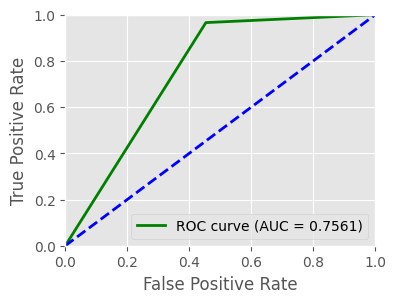

In [ ]:
fpr, tpr, thresholds = roc_curve(val_target, val_pred)
roc_auc = roc_auc_score(val_target, val_pred)

plt.figure(figsize=(4,3))

plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

In [ ]:
df_test_pred = pd.DataFrame()
df_test_pred['patient_id'] = df_test_clean_1['patient_id']
df_test_pred.set_index('patient_id', inplace=True)
df_test_pred['DiagPeriodL90D'] = [round(ele, 1) for ele in pred_prob]

submission = df_test_pred['DiagPeriodL90D']
# submission.to_csv(r'/content/drive/MyDrive/2_WiDS-Datathon-Kaggle_Jan24_healthCare/dataset/TargetEnc_PreProc_Trans_Corr-Features_u584124_WiDS24_2.csv')
print('File Created Sucessfully!')
print()
submission

# ### Dropping only Columns with >=40% Missing Value;
#  Imputing Mean for Numeric & Mode/Most_Freq for Categorical;
#  Target Encoding for Categorical Columns;
#  Correlation Features so 67 being Considered;
#  CatBoost Alg, No Patient-ID used


File Created Sucessfully!



patient_id
573710    0.9
593679    0.8
184532    0.8
447383    0.8
687972    0.9
         ... 
977076    0.8
922960    0.8
759690    0.9
911717    0.1
327597    0.8
Name: DiagPeriodL90D, Length: 5792, dtype: float64